# Distribution of NO<sub>2</sub> by CAMS and TROPOMI

### Main goal

Show side by side the total columns of NO<sub>2</sub> from CAMS and TROPOMI datasets.

### Selected period and study area
* Period: 21/06/2021 between 00:00:00 and 18:00:00
* Location: Northwest of Germany

### TODO
* Add apriori data to calculate component column 

## Imports and supporting functions

In [1]:
from sentinelsat.sentinel import SentinelAPI
import cdsapi
import cfgrib
import xarray as xr
import pandas as pd
import numpy as np
from itertools import product
import scipy.interpolate
import visual as f
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

In [2]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

## 1. Define study area

In [3]:
# Define limit latitudes and longitudes
lat_min = 50.8
lat_max = 53.2
lon_min = 6.8
lon_max = 9.2

# Create bbox
bbox = ((lon_min, lat_min), (lon_max, lat_max))

## 2. Define datasets

In [4]:
# Define component
component = 'nitrogen_dioxide'
component_nom = 'NO2'
component_mol_weight = 46 #g/mol

# CAMS: Define period
start_date = '2021-06-21'
end_date = '2021-06-21'

# TROPOMI: Define file and product name
file_name = 'd762cc7a-f037-4fb8-bc04-cac8e7f39f5b'
product_name = 'S5P_NRTI_L2__NO2____20210621T124026_20210621T124526_19112_01_010400_20210621T132518.nc'

## 3. CAMS data

### 3.1. Collect data

In [5]:
"""
# Access server 
c = cdsapi.Client()

# Retrieve GRIB file
c.retrieve(
    'cams-global-atmospheric-composition-forecasts',
    {
        'date': start_date + '/' + end_date,
        'type': 'forecast',
        'format': 'grib',
        'variable': component,
        'model_level': [
            '1', '2', '3',
            '4', '5', '6',
            '7', '8', '9',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31', '32', '33',
            '34', '35', '36',
            '37', '38', '39',
            '40', '41', '42',
            '43', '44', '45',
            '46', '47', '48',
            '49', '50', '51',
            '52', '53', '54',
            '55', '56', '57',
            '58', '59', '60',
            '61', '62', '63',
            '64', '65', '66',
            '67', '68', '69',
            '70', '71', '72',
            '73', '74', '75',
            '76', '77', '78',
            '79', '80', '81',
            '82', '83', '84',
            '85', '86', '87',
            '88', '89', '90',
            '91', '92', '93',
            '94', '95', '96',
            '97', '98', '99',
            '100', '101', '102',
            '103', '104', '105',
            '106', '107', '108',
            '109', '110', '111',
            '112', '113', '114',
            '115', '116', '117',
            '118', '119', '120',
            '121', '122', '123',
            '124', '125', '126',
            '127', '128', '129',
            '130', '131', '132',
            '133', '134', '135',
            '136', '137',
        ],
        'time': '00:00',
        'leadtime_hour': [
            '0', '12', '18', '6', 
        ],
    },
    'data/ads/' + component_nom + '/' + component_nom + '-' + start_date + '-' + end_date + '.grib')
    """

"\n# Access server \nc = cdsapi.Client()\n\n# Retrieve GRIB file\nc.retrieve(\n    'cams-global-atmospheric-composition-forecasts',\n    {\n        'date': start_date + '/' + end_date,\n        'type': 'forecast',\n        'format': 'grib',\n        'variable': component,\n        'model_level': [\n            '1', '2', '3',\n            '4', '5', '6',\n            '7', '8', '9',\n            '10', '11', '12',\n            '13', '14', '15',\n            '16', '17', '18',\n            '19', '20', '21',\n            '22', '23', '24',\n            '25', '26', '27',\n            '28', '29', '30',\n            '31', '32', '33',\n            '34', '35', '36',\n            '37', '38', '39',\n            '40', '41', '42',\n            '43', '44', '45',\n            '46', '47', '48',\n            '49', '50', '51',\n            '52', '53', '54',\n            '55', '56', '57',\n            '58', '59', '60',\n            '61', '62', '63',\n            '64', '65', '66',\n            '67', '68', '69

### 3.2. Read data

In [6]:
# Read as xarray dataset object
CAMS_ds = xr.open_dataset('data/ads/' + component_nom + '/' + component_nom + '-' + 
                          start_date + '-' + end_date + '.grib')

# Change longitude coordinates
CAMS_ds = CAMS_ds.assign_coords(longitude = (((CAMS_ds.longitude + 180) % 360) - 180)).sortby('longitude')
CAMS_ds = CAMS_ds.sortby('latitude')

# Change name to component
CAMS_ds = CAMS_ds.rename({'no2': 'component'})

CAMS_ds

<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 451, longitude: 900, step: 4)
Coordinates:
    time        datetime64[ns] ...
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 -90.0 -89.6 -89.2 -88.8 ... 89.2 89.6 90.0
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  (step) datetime64[ns] ...
Data variables:
    component   (step, hybrid, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-07-12T17:16 GRIB to CDM+CF via cfgrib-0.9.9...

### 3.3. Collect pressure data

In [7]:
# Read csv table with 137 levels
CAMS_levels = pd.read_csv('data/ads/137-levels.csv')

# Drop first row and set n as index hybrid
CAMS_levels = CAMS_levels.drop(0).reset_index(drop = True)
CAMS_levels = CAMS_levels.set_index('n')
CAMS_levels.index.names = ['hybrid']

# Change important columns to numeric
CAMS_levels['pf [hPa]'] = pd.to_numeric(CAMS_levels['pf [hPa]'])
CAMS_levels['Geopotential Altitude [m]'] = pd.to_numeric(CAMS_levels['Geopotential Altitude [m]'])
CAMS_levels['Density [kg/m^3]'] = pd.to_numeric(CAMS_levels['Density [kg/m^3]'])

CAMS_levels

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3]
hybrid,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127
...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650


### 3.4. Calculate layer depth

In [8]:
# Calculate difference from geopotential altitude
CAMS_levels['Depth [m]'] = CAMS_levels['Geopotential Altitude [m]'].diff(-1)

# Add layer depth to last row manually
CAMS_levels['Depth [m]'].iloc[-1] = CAMS_levels['Geopotential Altitude [m]'].iloc[-1]

CAMS_levels

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],Depth [m]
hybrid,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,2320.96
...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,22.96


### 3.5. Reduce data to study area

In [9]:
# Get indexes of the closest latitude and longitude
def nearest_neighbour(array, value):
    index = np.abs([x - value for x in array]).argmin(0)
    return index

In [10]:
# Get nearest longitude and latitude to bbox
lon_min_index = nearest_neighbour(CAMS_ds.longitude.data, bbox[0][0])
lon_max_index = nearest_neighbour(CAMS_ds.longitude.data, bbox[1][0])
lat_min_index = nearest_neighbour(CAMS_ds.latitude.data, bbox[0][1])
lat_max_index = nearest_neighbour(CAMS_ds.latitude.data, bbox[1][1])

# Define slices
slice_lat = slice(lat_min_index, lat_max_index + 1)
slice_lon = slice(lon_min_index, lon_max_index + 1)

# Set limits
CAMS_ds = CAMS_ds.isel(longitude = slice_lon, latitude = slice_lat)

CAMS_ds

<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 7, longitude: 7, step: 4)
Coordinates:
    time        datetime64[ns] 2021-06-21
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 50.8 51.2 51.6 52.0 52.4 52.8 53.2
  * longitude   (longitude) float64 6.8 7.2 7.6 8.0 8.4 8.8 9.2
    valid_time  (step) datetime64[ns] 2021-06-21 ... 2021-06-21T18:00:00
Data variables:
    component   (step, hybrid, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-07-12T17:16 GRIB to CDM+CF via cfgrib-0.9.9...

### 3.6. Convert units (kg/kg to mol/m2)

In [11]:
# Create xarray object from levels df
CAMS_levels_ds = CAMS_levels.to_xarray()

# From kg/kg to kg/m3
CAMS_ds = CAMS_ds * CAMS_levels_ds['Density [kg/m^3]']

# From kg/m3 to kg/m2
CAMS_ds = CAMS_ds * CAMS_levels_ds['Depth [m]']

# From kg/m2 to mol/m2
CAMS_ds = (CAMS_ds * 1000) / component_mol_weight

CAMS_ds

<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 7, longitude: 7, step: 4)
Coordinates:
    time        datetime64[ns] 2021-06-21
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 50.8 51.2 51.6 52.0 52.4 52.8 53.2
  * longitude   (longitude) float64 6.8 7.2 7.6 8.0 8.4 8.8 9.2
    valid_time  (step) datetime64[ns] 2021-06-21 ... 2021-06-21T18:00:00
Data variables:
    component   (step, hybrid, latitude, longitude) float64 6.55e-09 ... 2.11...

## 4. TROPOMI data

### 4.1. Collect data

In [12]:
"""
# Access the API
user = 's5pguest' 
password = 's5pguest' 
api = SentinelAPI(user, password, 'https://s5phub.copernicus.eu/dhus')

# Get NetCDF file
api.download(file_name, directory_path = 'data/tropomi/' + component_nom)
"""

"\n# Access the API\nuser = 's5pguest' \npassword = 's5pguest' \napi = SentinelAPI(user, password, 'https://s5phub.copernicus.eu/dhus')\n\n# Get NetCDF file\napi.download(file_name, directory_path = 'data/tropomi/' + component_nom)\n"

### 4.2. Read data

In [13]:
# Read as xarray dataset object
TROPOMI_ds = xr.open_dataset('data/tropomi/' + component_nom + '/' + product_name, group = 'PRODUCT')

# Change name of component
TROPOMI_ds = TROPOMI_ds.rename({'nitrogendioxide_tropospheric_column': 'TROPOMI_column'})

TROPOMI_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 373, time: 1, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    TROPOMI_column                                        (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...

### 4.3. Calculate pressure

In [14]:
# Read support data to calculate pressure
support_ds = xr.open_dataset('data/tropomi/' + component_nom + '/' + product_name, group = 'PRODUCT/SUPPORT_DATA/INPUT_DATA')

# Calculate pressure as p = ap + b * ps and change units from Pa to hPa
p = TROPOMI_ds.tm5_constant_a + TROPOMI_ds.tm5_constant_b * support_ds.surface_pressure / 100
TROPOMI_ds = TROPOMI_ds.assign(pressure = p)

TROPOMI_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 373, time: 1, vertices: 2)
Coordinates:
  * ground_pixel                                          (ground_pixel) float64 ...
  * scanline                                              (scanline) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables: (12/13)
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    TROPOMI_column                                        (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    ...                                                    ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...
    pressure                                              (layer, vertices, time, scanline, ground_pixel) float32 ...

### 4.4. Reduce data to study area

In [15]:
"""
# Create dataframe with scanlines and ground pixels
TROPOMI_df = []
TROPOMI_df = pd.DataFrame(list(product(TROPOMI_ds.ground_pixel.values, TROPOMI_ds.scanline.values)), 
                          columns = ['ground_pixel', 'scanline'])

# Find corresponding latitudes and longitudes                          
for index, row in TROPOMI_df.iterrows():
    TROPOMI_df.loc[index,'latitude'] = TROPOMI_ds.latitude.sel(
                                        scanline = TROPOMI_df['scanline'].loc[index], 
                                        ground_pixel = TROPOMI_df['ground_pixel'].loc[index]).values
                                        
    TROPOMI_df.loc[index,'longitude'] = TROPOMI_ds.longitude.sel(
                                        scanline = TROPOMI_df['scanline'].loc[index], 
                                        ground_pixel = TROPOMI_df['ground_pixel'].loc[index]).values

# Save as csv
TROPOMI_df.to_csv('data/tropomi/TROPOMI_df_' + product_name + '.csv', index = False)
"""

"\n# Create dataframe with scanlines and ground pixels\nTROPOMI_df = []\nTROPOMI_df = pd.DataFrame(list(product(TROPOMI_ds.ground_pixel.values, TROPOMI_ds.scanline.values)), \n                          columns = ['ground_pixel', 'scanline'])\n\n# Find corresponding latitudes and longitudes                          \nfor index, row in TROPOMI_df.iterrows():\n    TROPOMI_df.loc[index,'latitude'] = TROPOMI_ds.latitude.sel(\n                                        scanline = TROPOMI_df['scanline'].loc[index], \n                                        ground_pixel = TROPOMI_df['ground_pixel'].loc[index]).values\n                                        \n    TROPOMI_df.loc[index,'longitude'] = TROPOMI_ds.longitude.sel(\n                                        scanline = TROPOMI_df['scanline'].loc[index], \n                                        ground_pixel = TROPOMI_df['ground_pixel'].loc[index]).values\n\n# Save as csv\nTROPOMI_df.to_csv('data/tropomi/TROPOMI_df_' + product_name + '.csv',

In [16]:
# Read csv
TROPOMI_df = pd.read_csv('data/tropomi/TROPOMI_df_' + product_name + '.csv')

# Set limits
TROPOMI_df = TROPOMI_df[(TROPOMI_df['latitude'] >= lat_min) & (TROPOMI_df['latitude'] <= lat_max)]
TROPOMI_df = TROPOMI_df[(TROPOMI_df['longitude'] >= lon_min) & (TROPOMI_df['longitude'] <= lon_max)]

TROPOMI_df

,ground_pixel,scanline,latitude,longitude
123697,331.0,234.0,50.832016,6.815896
124070,332.0,234.0,50.837315,6.883728
124071,332.0,235.0,50.886108,6.867898
124072,332.0,236.0,50.934841,6.852077
124073,332.0,237.0,50.983631,6.836212
...,...,...,...,...
137542,368.0,278.0,53.141014,9.091036
137543,368.0,279.0,53.189816,9.077573
137914,369.0,277.0,53.095341,9.198322
137915,369.0,278.0,53.144146,9.184937


In [17]:
# Get nearest longitude and latitude to bbox
gp_min_index = nearest_neighbour(TROPOMI_ds.ground_pixel.data, np.min(TROPOMI_df['ground_pixel']))
gp_max_index = nearest_neighbour(TROPOMI_ds.ground_pixel.data, np.max(TROPOMI_df['ground_pixel']))
sl_min_index = nearest_neighbour(TROPOMI_ds.scanline.data, np.min(TROPOMI_df['scanline']))
sl_max_index = nearest_neighbour(TROPOMI_ds.scanline.data, np.max(TROPOMI_df['scanline']))

# Define slices
slice_gp = slice(gp_min_index, gp_max_index)
slice_sl = slice(sl_min_index, sl_max_index)

# Set limits
TROPOMI_ds = TROPOMI_ds.isel(ground_pixel = slice_gp, scanline = slice_sl)

TROPOMI_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 38, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 50, time: 1, vertices: 2)
Coordinates:
  * ground_pixel                                          (ground_pixel) float64 ...
  * scanline                                              (scanline) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables: (12/13)
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    TROPOMI_column                                        (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    ...                                                    ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...
    pressure                                              (layer, vertices, time, scanline, ground_pixel) float32 ...

### 4.5. Calculate column averaging kernels

In [18]:
kernel_column_da = xr.where(TROPOMI_ds.layer > TROPOMI_ds.tm5_tropopause_layer_index, 0, 
                            TROPOMI_ds.averaging_kernel * (TROPOMI_ds.air_mass_factor_total / 
                            TROPOMI_ds.air_mass_factor_troposphere))

TROPOMI_ds = TROPOMI_ds.assign(kernel_column = kernel_column_da)

TROPOMI_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 38, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 50, time: 1, vertices: 2)
Coordinates:
  * ground_pixel                                          (ground_pixel) float64 ...
  * scanline                                              (scanline) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables: (12/14)
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    TROPOMI_column                                        (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    ...                                                    ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...
    pressure                                              (layer, vertices, time, scanline, ground_pixel) float32 ...
    kernel_column                                         (layer, time, scanline, ground_pixel) float32 ...

## 5. Data combination

### 5.1. Linear interpolation of CAMS data to 100x100

In [19]:
# Grid data from CAMS
x = CAMS_ds.longitude.values
y = CAMS_ds.latitude.values
x_old, y_old = np.meshgrid(x, y)

# Grid data in 100x100
xi = np.linspace(lon_min, lon_max, 100)
yi = np.linspace(lat_min, lat_max, 100)
x_new, y_new = np.meshgrid(xi, yi)

da_hybrid = []
da_step = []

for step in range(CAMS_ds.step.size):

    for hybrid in range(CAMS_ds.hybrid.size):
        
        z = CAMS_ds.isel(hybrid = hybrid, step = step).component.values

        zi = scipy.interpolate.griddata((x_old.flatten(), y_old.flatten()), 
                                        z.flatten(), (xi[None,:], yi[:,None]), 
                                        method = 'linear')

        # Create data array for each layer
        da = xr.DataArray(data = xr.Variable(('lon', 'lat'), zi),
                        dims = ['lon', 'lat'],
                        coords = {'longitude': xr.Variable('lon', xi),
                                    'latitude': xr.Variable('lat', yi)
                                }
        )

        # Append arrays for each layer
        da_hybrid.append(da)

    # Concatenate data arrays for all layers
    da_hybrid_concat = xr.concat(da_hybrid, pd.Index(range(CAMS_ds.hybrid.size), 
                                                     name = 'hybrid'))

    da_step.append(da_hybrid_concat)
    da_hybrid = []

CAMS_ds_new = xr.concat(da_step, pd.Index(CAMS_ds.valid_time.values, 
                                          name = 'valid_time'))
CAMS_ds_new

<xarray.DataArray (valid_time: 4, hybrid: 137, lon: 100, lat: 100)>
array([[[[           nan, 6.54913121e-09, 6.54792967e-09, ...,
          6.42909791e-09, 6.42813239e-09,            nan],
         [           nan, 6.55038559e-09, 6.54918405e-09, ...,
          6.42855418e-09, 6.42758865e-09,            nan],
         [           nan, 6.55210595e-09, 6.55043842e-09, ...,
          6.42801044e-09, 6.42704492e-09,            nan],
         ...,
         [           nan, 6.65584410e-09, 6.65414358e-09, ...,
          6.42567796e-09, 6.42348321e-09,            nan],
         [           nan, 6.65631179e-09, 6.65461127e-09, ...,
          6.42613101e-09, 6.42381514e-09,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan]],

        [[           nan, 6.67175849e-09, 6.67252167e-09, ...,
          6.67843930e-09, 6.67781735e-09,            nan],
         [           nan, 6.66447181e-09, 6.66523499e-09, ...,
          6.67498110e-09, 6.67435915e-09,            nan],
         [           nan, 6.65674904e-09, 6.65794831e-09, ...,
          6.67152291e-09, 6.67090096e-09,            nan],
...
         [           nan, 2.97449176e-06, 2.93569010e-06, ...,
          4.03491999e-06, 4.07938745e-06,            nan],
         [           nan, 2.93164050e-06, 2.89283884e-06, ...,
          4.02709975e-06, 4.08787200e-06,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan]],

        [[           nan, 3.28439453e-06, 3.25911805e-06, ...,
          1.24489772e-06, 1.22246686e-06,            nan],
         [           nan, 3.31747441e-06, 3.29219793e-06, ...,
          1.30610612e-06, 1.28367526e-06,            nan],
         [           nan, 3.35573913e-06, 3.32527780e-06, ...,
          1.36731452e-06, 1.34488366e-06,            nan],
         ...,
         [           nan, 1.53206544e-06, 1.51147476e-06, ...,
          2.05859523e-06, 2.07985637e-06,            nan],
         [           nan, 1.51953593e-06, 1.49894524e-06, ...,
          2.05717620e-06, 2.08740405e-06,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan]]]])
Coordinates:
    longitude   (lon) float64 6.8 6.824 6.848 6.873 ... 9.127 9.152 9.176 9.2
    latitude    (lat) float64 50.8 50.82 50.85 50.87 ... 53.13 53.15 53.18 53.2
  * hybrid      (hybrid) int64 0 1 2 3 4 5 6 7 ... 130 131 132 133 134 135 136
  * valid_time  (valid_time) datetime64[ns] 2021-06-21 ... 2021-06-21T18:00:00
Dimensions without coordinates: lon, lat

### 5.2. Visualize data at surface (Step 2)

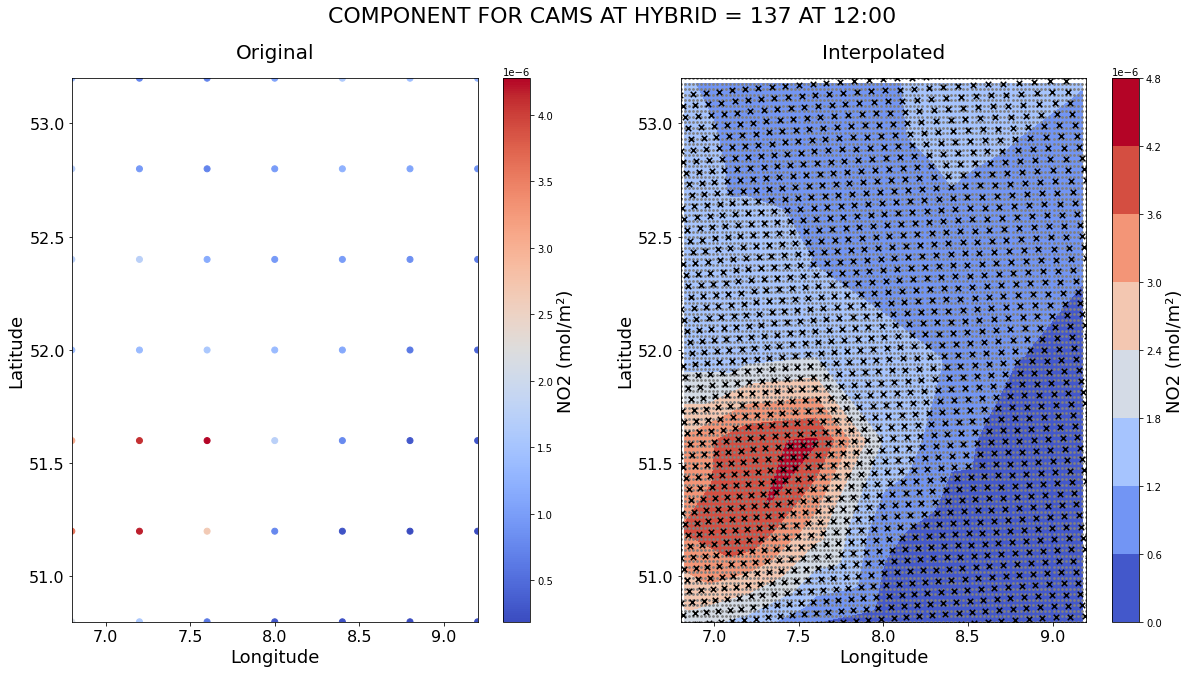

In [20]:
z_1L = CAMS_ds.isel(hybrid = 136, step = 2).component.values
zi_1L = CAMS_ds_new.isel(hybrid = 136, valid_time = 2).values

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))

# Show old CAMS grid
im1 = ax[0].scatter(x_old, y_old, c = z_1L, cmap = 'coolwarm', vmin = np.nanmin(z_1L), vmax = np.nanmax(z_1L))

# Show contour plot of new CAMS data
im2 = ax[1].contourf(x_new, y_new, zi_1L, cmap = 'coolwarm', vmin = np.nanmin(zi_1L), vmax = np.nanmax(zi_1L))

# Show new CAMS grid
ax[1].scatter(x_new, y_new, marker = 'o', c = 'grey', s = 3)

# Show TROPOMI grid
TROPOMI_lat = TROPOMI_ds['latitude'].values
TROPOMI_lon = TROPOMI_ds['longitude'].values
ax[1].scatter(TROPOMI_lon, TROPOMI_lat, marker = 'x', c = 'black', s = 30)

# Add colorbars
cbr1 = fig.colorbar(im1, ax = ax[0])
cbr2 = fig.colorbar(im2, ax = ax[1])
cbr1.set_label(f'{component_nom} (mol/m²)', fontsize = 18)
cbr2.set_label(f'{component_nom} (mol/m²)', fontsize = 18)

for i in range(2):
    
    ax[i].set_xlim([lon_min, lon_max])
    ax[i].set_ylim([lat_min, lat_max])
    ax[i].set_xlabel('Longitude', fontsize = 18)
    ax[i].set_ylabel('Latitude', fontsize = 18)
    ax[i].tick_params(labelsize = 16)

ax[0].set_title('Original', fontsize = 20, pad = 20)
ax[1].set_title('Interpolated', fontsize = 20, pad = 20)
fig.suptitle('COMPONENT FOR CAMS AT HYBRID = 137 AT 12:00', fontsize = 22)
plt.show()

### 5.3. Transform TROPOMI ds into df

In [21]:
TROPOMI_df = TROPOMI_ds.to_dataframe()

TROPOMI_df = TROPOMI_df.drop(columns=['nitrogendioxide_tropospheric_column_precision', 
                                      'nitrogendioxide_tropospheric_column_precision_kernel',
                                      'averaging_kernel',
                                      'air_mass_factor_troposphere',
                                      'air_mass_factor_total',
                                      'tm5_tropopause_layer_index',
                                      'tm5_constant_a',
                                      'tm5_constant_b',
                                      'time_utc'])

TROPOMI_df = TROPOMI_df.droplevel(['corner', 'intensity_offset_polynomial_exponents', 'polynomial_exponents']).drop_duplicates()
TROPOMI_df = TROPOMI_df.groupby(by = ['layer', 'ground_pixel', 'scanline', 'time', 'delta_time']).mean()
TROPOMI_df = TROPOMI_df.reset_index(level = 'delta_time')
TROPOMI_df

delta_time   latitude  \
layer ground_pixel scanline time                                            
0.0   331.0        231.0    2021-06-21 2021-06-21 12:43:34.632  50.685669   
                   232.0    2021-06-21 2021-06-21 12:43:35.471  50.734451   
                   233.0    2021-06-21 2021-06-21 12:43:36.311  50.783237   
                   234.0    2021-06-21 2021-06-21 12:43:37.151  50.832016   
                   235.0    2021-06-21 2021-06-21 12:43:37.991  50.880810   
...                                                        ...        ...   
33.0  368.0        276.0    2021-06-21 2021-06-21 12:44:12.431  53.043438   
                   277.0    2021-06-21 2021-06-21 12:44:13.271  53.092209   
                   278.0    2021-06-21 2021-06-21 12:44:14.111  53.141014   
                   279.0    2021-06-21 2021-06-21 12:44:14.951  53.189816   
                   280.0    2021-06-21 2021-06-21 12:44:15.791  53.238621   

                                        longitude  qa_value  TROPOMI_column  \
layer ground_pixel scanline time                                              
0.0   331.0        231.0    2021-06-21   6.863347      0.74        0.000036   
                   232.0    2021-06-21   6.847545      0.74        0.000039   
                   233.0    2021-06-21   6.831749      0.74        0.000027   
                   234.0    2021-06-21   6.815896      0.74        0.000054   
                   235.0    2021-06-21   6.799994      0.74        0.000131   
...                                           ...       ...             ...   
33.0  368.0        276.0    2021-06-21   9.117963      0.74        0.000049   
                   277.0    2021-06-21   9.104528      0.74        0.000056   
                   278.0    2021-06-21   9.091036      0.74        0.000061   
                   279.0    2021-06-21   9.077573      0.74        0.000067   
                   280.0    2021-06-21   9.064083      0.74        0.000079   

                                           pressure  kernel_column  
layer ground_pixel scanline time                                    
0.0   331.0        231.0    2021-06-21   996.327698       0.006776  
                   232.0    2021-06-21   997.756592       0.013234  
                   233.0    2021-06-21   999.079712       0.002407  
                   234.0    2021-06-21  1001.020142       0.002590  
                   235.0    2021-06-21  1001.737427       0.002717  
...                                             ...            ...  
33.0  368.0        276.0    2021-06-21     0.000000       0.000000  
                   277.0    2021-06-21     0.000000       0.000000  
                   278.0    2021-06-21     0.000000       0.000000  
                   279.0    2021-06-21     0.000000       0.000000  
                   280.0    2021-06-21     0.000000       0.000000  

[64600 rows x 7 columns]

### 5.4. Pass NaNs to data with qa_value under 0.5

In [22]:
TROPOMI_df.loc[TROPOMI_df['qa_value'] < 0.5, ['TROPOMI_column', 'kernel_column']] = float('NaN')
TROPOMI_df

delta_time   latitude  \
layer ground_pixel scanline time                                            
0.0   331.0        231.0    2021-06-21 2021-06-21 12:43:34.632  50.685669   
                   232.0    2021-06-21 2021-06-21 12:43:35.471  50.734451   
                   233.0    2021-06-21 2021-06-21 12:43:36.311  50.783237   
                   234.0    2021-06-21 2021-06-21 12:43:37.151  50.832016   
                   235.0    2021-06-21 2021-06-21 12:43:37.991  50.880810   
...                                                        ...        ...   
33.0  368.0        276.0    2021-06-21 2021-06-21 12:44:12.431  53.043438   
                   277.0    2021-06-21 2021-06-21 12:44:13.271  53.092209   
                   278.0    2021-06-21 2021-06-21 12:44:14.111  53.141014   
                   279.0    2021-06-21 2021-06-21 12:44:14.951  53.189816   
                   280.0    2021-06-21 2021-06-21 12:44:15.791  53.238621   

                                        longitude  qa_value  TROPOMI_column  \
layer ground_pixel scanline time                                              
0.0   331.0        231.0    2021-06-21   6.863347      0.74        0.000036   
                   232.0    2021-06-21   6.847545      0.74        0.000039   
                   233.0    2021-06-21   6.831749      0.74        0.000027   
                   234.0    2021-06-21   6.815896      0.74        0.000054   
                   235.0    2021-06-21   6.799994      0.74        0.000131   
...                                           ...       ...             ...   
33.0  368.0        276.0    2021-06-21   9.117963      0.74        0.000049   
                   277.0    2021-06-21   9.104528      0.74        0.000056   
                   278.0    2021-06-21   9.091036      0.74        0.000061   
                   279.0    2021-06-21   9.077573      0.74        0.000067   
                   280.0    2021-06-21   9.064083      0.74        0.000079   

                                           pressure  kernel_column  
layer ground_pixel scanline time                                    
0.0   331.0        231.0    2021-06-21   996.327698       0.006776  
                   232.0    2021-06-21   997.756592       0.013234  
                   233.0    2021-06-21   999.079712       0.002407  
                   234.0    2021-06-21  1001.020142       0.002590  
                   235.0    2021-06-21  1001.737427       0.002717  
...                                             ...            ...  
33.0  368.0        276.0    2021-06-21     0.000000       0.000000  
                   277.0    2021-06-21     0.000000       0.000000  
                   278.0    2021-06-21     0.000000       0.000000  
                   279.0    2021-06-21     0.000000       0.000000  
                   280.0    2021-06-21     0.000000       0.000000  

[64600 rows x 7 columns]

### 5.5. Match data

In [23]:
match_df = TROPOMI_df

CAMS_latitudes = CAMS_ds_new.latitude.data
CAMS_longitudes = CAMS_ds_new.longitude.data
CAMS_pressures = CAMS_levels['pf [hPa]'].to_numpy()
CAMS_times = CAMS_ds_new.valid_time.data

match_df['lat_index'] = match_df.apply(lambda row: nearest_neighbour(CAMS_latitudes, row['latitude']), axis = 1)
match_df['lon_index'] = match_df.apply(lambda row: nearest_neighbour(CAMS_longitudes, row['longitude']), axis = 1)
match_df['lay_index'] = match_df.apply(lambda row: nearest_neighbour(CAMS_pressures, row['pressure']), axis = 1)
match_df['time_index'] = match_df.apply(lambda row: nearest_neighbour(CAMS_times, row['delta_time']), axis = 1)
match_df['CAMS_time'] = match_df.apply(lambda row: CAMS_ds_new.valid_time[row['time_index']].values, axis = 1)

match_df['CAMS_component'] = match_df.apply(lambda row: CAMS_ds_new.isel(hybrid = int(row['lay_index']) - 1, 
                        lat = int(row['lat_index']), lon = int(row['lon_index']), valid_time = int(row['time_index'])).values, axis = 1)

match_df

delta_time   latitude  \
layer ground_pixel scanline time                                            
0.0   331.0        231.0    2021-06-21 2021-06-21 12:43:34.632  50.685669   
                   232.0    2021-06-21 2021-06-21 12:43:35.471  50.734451   
                   233.0    2021-06-21 2021-06-21 12:43:36.311  50.783237   
                   234.0    2021-06-21 2021-06-21 12:43:37.151  50.832016   
                   235.0    2021-06-21 2021-06-21 12:43:37.991  50.880810   
...                                                        ...        ...   
33.0  368.0        276.0    2021-06-21 2021-06-21 12:44:12.431  53.043438   
                   277.0    2021-06-21 2021-06-21 12:44:13.271  53.092209   
                   278.0    2021-06-21 2021-06-21 12:44:14.111  53.141014   
                   279.0    2021-06-21 2021-06-21 12:44:14.951  53.189816   
                   280.0    2021-06-21 2021-06-21 12:44:15.791  53.238621   

                                        longitude  qa_value  TROPOMI_column  \
layer ground_pixel scanline time                                              
0.0   331.0        231.0    2021-06-21   6.863347      0.74        0.000036   
                   232.0    2021-06-21   6.847545      0.74        0.000039   
                   233.0    2021-06-21   6.831749      0.74        0.000027   
                   234.0    2021-06-21   6.815896      0.74        0.000054   
                   235.0    2021-06-21   6.799994      0.74        0.000131   
...                                           ...       ...             ...   
33.0  368.0        276.0    2021-06-21   9.117963      0.74        0.000049   
                   277.0    2021-06-21   9.104528      0.74        0.000056   
                   278.0    2021-06-21   9.091036      0.74        0.000061   
                   279.0    2021-06-21   9.077573      0.74        0.000067   
                   280.0    2021-06-21   9.064083      0.74        0.000079   

                                           pressure  kernel_column  lat_index  \
layer ground_pixel scanline time                                                
0.0   331.0        231.0    2021-06-21   996.327698       0.006776          0   
                   232.0    2021-06-21   997.756592       0.013234          0   
                   233.0    2021-06-21   999.079712       0.002407          0   
                   234.0    2021-06-21  1001.020142       0.002590          1   
                   235.0    2021-06-21  1001.737427       0.002717          3   
...                                             ...            ...        ...   
33.0  368.0        276.0    2021-06-21     0.000000       0.000000         93   
                   277.0    2021-06-21     0.000000       0.000000         95   
                   278.0    2021-06-21     0.000000       0.000000         97   
                   279.0    2021-06-21     0.000000       0.000000         99   
                   280.0    2021-06-21     0.000000       0.000000         99   

                                        lon_index  lay_index  time_index  \
layer ground_pixel scanline time                                           
0.0   331.0        231.0    2021-06-21          3        131           2   
                   232.0    2021-06-21          2        131           2   
                   233.0    2021-06-21          1        132           2   
                   234.0    2021-06-21          1        132           2   
                   235.0    2021-06-21          0        132           2   
...                                           ...        ...         ...   
33.0  368.0        276.0    2021-06-21         96          0           2   
                   277.0    2021-06-21         95          0           2   
                   278.0    2021-06-21         95          0           2   
                   279.0    2021-06-21         94          0           2   
                   280.0    2021-06-21         93       

### 5.6. Calculate CAMS columns

In [24]:
# Calculate values to generate CAMS column from sum in the next step
match_df['CAMS_column'] = match_df.apply(lambda row: row['CAMS_component'] * 
                                                     row['kernel_column'], 
                                                     axis = 1)

match_df

delta_time   latitude  \
layer ground_pixel scanline time                                            
0.0   331.0        231.0    2021-06-21 2021-06-21 12:43:34.632  50.685669   
                   232.0    2021-06-21 2021-06-21 12:43:35.471  50.734451   
                   233.0    2021-06-21 2021-06-21 12:43:36.311  50.783237   
                   234.0    2021-06-21 2021-06-21 12:43:37.151  50.832016   
                   235.0    2021-06-21 2021-06-21 12:43:37.991  50.880810   
...                                                        ...        ...   
33.0  368.0        276.0    2021-06-21 2021-06-21 12:44:12.431  53.043438   
                   277.0    2021-06-21 2021-06-21 12:44:13.271  53.092209   
                   278.0    2021-06-21 2021-06-21 12:44:14.111  53.141014   
                   279.0    2021-06-21 2021-06-21 12:44:14.951  53.189816   
                   280.0    2021-06-21 2021-06-21 12:44:15.791  53.238621   

                                        longitude  qa_value  TROPOMI_column  \
layer ground_pixel scanline time                                              
0.0   331.0        231.0    2021-06-21   6.863347      0.74        0.000036   
                   232.0    2021-06-21   6.847545      0.74        0.000039   
                   233.0    2021-06-21   6.831749      0.74        0.000027   
                   234.0    2021-06-21   6.815896      0.74        0.000054   
                   235.0    2021-06-21   6.799994      0.74        0.000131   
...                                           ...       ...             ...   
33.0  368.0        276.0    2021-06-21   9.117963      0.74        0.000049   
                   277.0    2021-06-21   9.104528      0.74        0.000056   
                   278.0    2021-06-21   9.091036      0.74        0.000061   
                   279.0    2021-06-21   9.077573      0.74        0.000067   
                   280.0    2021-06-21   9.064083      0.74        0.000079   

                                           pressure  kernel_column  lat_index  \
layer ground_pixel scanline time                                                
0.0   331.0        231.0    2021-06-21   996.327698       0.006776          0   
                   232.0    2021-06-21   997.756592       0.013234          0   
                   233.0    2021-06-21   999.079712       0.002407          0   
                   234.0    2021-06-21  1001.020142       0.002590          1   
                   235.0    2021-06-21  1001.737427       0.002717          3   
...                                             ...            ...        ...   
33.0  368.0        276.0    2021-06-21     0.000000       0.000000         93   
                   277.0    2021-06-21     0.000000       0.000000         95   
                   278.0    2021-06-21     0.000000       0.000000         97   
                   279.0    2021-06-21     0.000000       0.000000         99   
                   280.0    2021-06-21     0.000000       0.000000         99   

                                        lon_index  lay_index  time_index  \
layer ground_pixel scanline time                                           
0.0   331.0        231.0    2021-06-21          3        131           2   
                   232.0    2021-06-21          2        131           2   
                   233.0    2021-06-21          1        132           2   
                   234.0    2021-06-21          1        132           2   
                   235.0    2021-06-21          0        132           2   
...                                           ...        ...         ...   
33.0  368.0        276.0    2021-06-21         96          0           2   
                   277.0    2021-06-21         95          0           2   
                   278.0    2021-06-21         95          0           2   
                   279.0    2021-06-21         94          0           2   
                   280.0    2021-06-21         93       

In [25]:
match_ds = match_df.to_xarray()
match_ds

<xarray.Dataset>
Dimensions:         (ground_pixel: 38, layer: 34, scanline: 50, time: 1)
Coordinates:
  * layer           (layer) float64 0.0 1.0 2.0 3.0 4.0 ... 30.0 31.0 32.0 33.0
  * ground_pixel    (ground_pixel) float64 331.0 332.0 333.0 ... 367.0 368.0
  * scanline        (scanline) float64 231.0 232.0 233.0 ... 278.0 279.0 280.0
  * time            (time) datetime64[ns] 2021-06-21
Data variables: (12/14)
    delta_time      (layer, ground_pixel, scanline, time) datetime64[ns] 2021...
    latitude        (layer, ground_pixel, scanline, time) float32 50.69 ... 5...
    longitude       (layer, ground_pixel, scanline, time) float32 6.863 ... 9...
    qa_value        (layer, ground_pixel, scanline, time) float32 0.74 ... 0.74
    TROPOMI_column  (layer, ground_pixel, scanline, time) float32 3.629e-05 ....
    pressure        (layer, ground_pixel, scanline, time) float32 996.3 ... 0.0
    ...              ...
    lon_index       (layer, ground_pixel, scanline, time) int64 3 2 1 ... 94 93
    lay_index       (layer, ground_pixel, scanline, time) int64 131 131 ... 0 0
    time_index      (layer, ground_pixel, scanline, time) int64 2 2 2 ... 2 2 2
    CAMS_time       (layer, ground_pixel, scanline, time) datetime64[ns] 2021...
    CAMS_component  (layer, ground_pixel, scanline, time) object nan nan ... nan
    CAMS_column     (layer, ground_pixel, scanline, time) float64 nan ... nan

In [26]:
# Read latitudes, longituds and CAMS time from data array
latitude = match_ds.latitude.mean(dim = 'layer')
longitude = match_ds.longitude.mean(dim = 'layer')
CAMS_time = match_ds.CAMS_time.mean(dim = 'layer')

In [27]:
# Get sum of CAMS data of each layer to get column data
CAMS = match_ds.CAMS_column.sum(dim = 'layer', skipna = False)
CAMS = CAMS.assign_coords(latitude = latitude, longitude = longitude, 
                          CAMS_time = CAMS_time)
CAMS

<xarray.DataArray 'CAMS_column' (ground_pixel: 38, scanline: 50, time: 1)>
array([[[           nan],
        [           nan],
        [           nan],
        ...,
        [1.21167126e-05],
        [1.16302151e-05],
        [1.13409866e-05]],

       [[           nan],
        [           nan],
        [           nan],
        ...,
        [1.20905902e-05],
        [1.16235995e-05],
        [1.15166252e-05]],

       [[           nan],
        [           nan],
        [           nan],
        ...,
...
        ...,
        [7.77799746e-05],
        [8.09387416e-05],
        [           nan]],

       [[           nan],
        [           nan],
        [           nan],
        ...,
        [8.54399024e-05],
        [9.28743028e-05],
        [           nan]],

       [[           nan],
        [           nan],
        [           nan],
        ...,
        [9.20758603e-05],
        [           nan],
        [           nan]]])
Coordinates:
  * ground_pixel  (ground_pixel) float64 331.0 332.0 333.0 ... 366.0 367.0 368.0
  * scanline      (scanline) float64 231.0 232.0 233.0 ... 278.0 279.0 280.0
  * time          (time) datetime64[ns] 2021-06-21
    latitude      (ground_pixel, scanline, time) float32 50.69 50.73 ... 53.24
    longitude     (ground_pixel, scanline, time) float32 6.863 6.848 ... 9.064
    CAMS_time     (ground_pixel, scanline, time) datetime64[ns] 2021-06-21T12...

In [28]:
# Get mean of TROPOMI data of each layer (it must be equal)
TROPOMI = match_ds.TROPOMI_column.mean(dim = 'layer', skipna = False)
TROPOMI = TROPOMI.assign_coords(latitude = latitude, longitude = longitude)
TROPOMI

<xarray.DataArray 'TROPOMI_column' (ground_pixel: 38, scanline: 50, time: 1)>
array([[[3.6290370e-05],
        [3.9425649e-05],
        [2.7211847e-05],
        ...,
        [3.6554717e-05],
        [3.2072068e-05],
        [3.8220973e-05]],

       [[3.4518991e-05],
        [3.9186107e-05],
        [6.2669940e-05],
        ...,
        [5.4898912e-05],
        [3.8853392e-05],
        [3.7684029e-05]],

       [[3.9777140e-05],
        [5.1603423e-05],
        [9.2282884e-05],
        ...,
...
        ...,
        [5.1214214e-05],
        [5.2327749e-05],
        [6.2272054e-05]],

       [[3.0466475e-05],
        [1.8473127e-05],
        [3.7607391e-05],
        ...,
        [5.5560351e-05],
        [6.2532112e-05],
        [6.9845213e-05]],

       [[9.5251880e-06],
        [2.3629111e-05],
        [1.4440799e-05],
        ...,
        [6.0669721e-05],
        [6.7401532e-05],
        [7.8599049e-05]]], dtype=float32)
Coordinates:
  * ground_pixel  (ground_pixel) float64 331.0 332.0 333.0 ... 366.0 367.0 368.0
  * scanline      (scanline) float64 231.0 232.0 233.0 ... 278.0 279.0 280.0
  * time          (time) datetime64[ns] 2021-06-21
    latitude      (ground_pixel, scanline, time) float32 50.69 50.73 ... 53.24
    longitude     (ground_pixel, scanline, time) float32 6.863 6.848 ... 9.064

## 6. Visualize data

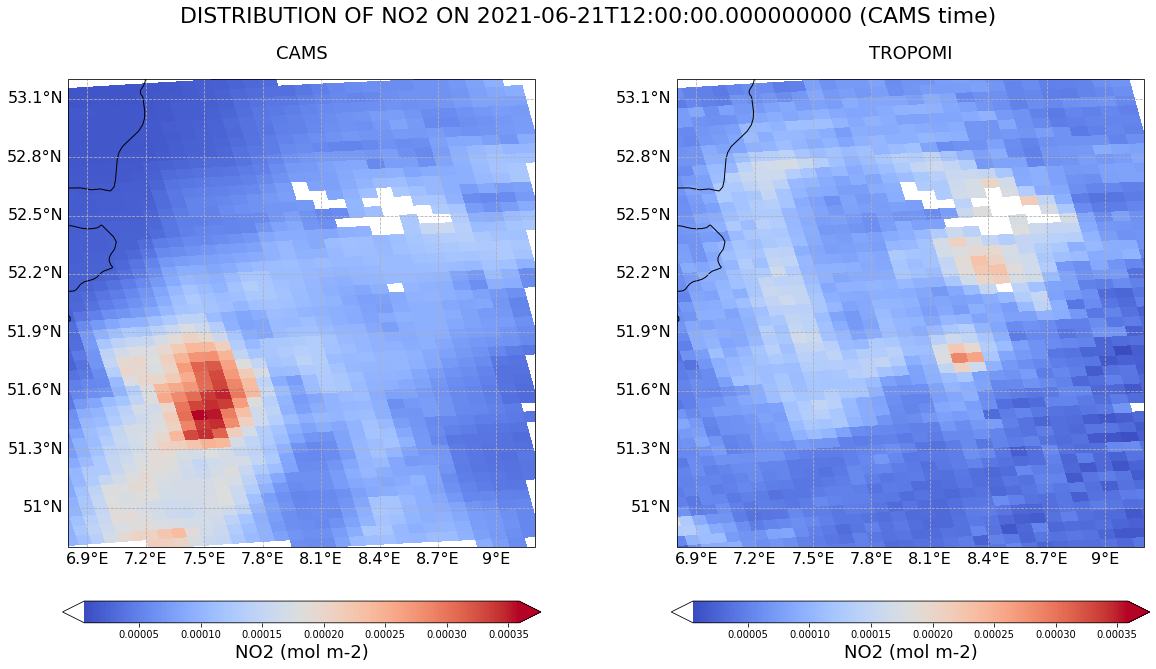

In [29]:
units = component_nom + ' (' + TROPOMI_ds.TROPOMI_column.units + ')'
projection = ccrs.PlateCarree()

for t in range(TROPOMI.time.size):
    
    fig, axs = plt.subplots(1, 2, figsize = (20, 10), subplot_kw = {'projection': projection})
    
    # Define vmin
    if np.nanmin(TROPOMI.isel(time = t)) < np.nanmin(CAMS.isel(time = t)):
        vmin = np.nanmin(TROPOMI.isel(time = t))
    else:
        vmin = np.nanmin(CAMS.isel(time = t))

    # Define vmax
    if np.nanmax(TROPOMI.isel(time = t)) < np.nanmax(CAMS.isel(time = t)):
        vmax = np.nanmax(CAMS.isel(time = t))
    else:
        vmax = np.nanmax(TROPOMI.isel(time = t))
   
    # First plot - CAMS
    array = CAMS.isel(time = t)
    long_name = 'CAMS'
    f.visualize_pcolormesh(
                            fig = fig, axs = axs[0],
                            data_array = array.fillna(-999),
                            longitude = array.longitude,
                            latitude = array.latitude,
                            projection = ccrs.PlateCarree(),
                            color_scale = 'coolwarm',
                            long_name = long_name,
                            units = units,
                            vmin = vmin, 
                            vmax = vmax, 
                            set_global = False,
                            lonmin = bbox[0][0],
                            lonmax = bbox[1][0],
                            latmin = bbox[0][1],
                            latmax = bbox[1][1]
                            )

    # Second plot - TROPOMI
    array = TROPOMI.isel(time = t)
    long_name = 'TROPOMI'
    f.visualize_pcolormesh(
                            fig = fig, axs = axs[1],
                            data_array = array,
                            longitude = array.longitude,
                            latitude = array.latitude,
                            projection = ccrs.PlateCarree(),
                            color_scale = 'coolwarm',
                            long_name = long_name,
                            units = units,
                            vmin = vmin,  
                            vmax = vmax, 
                            set_global = False,
                            lonmin = bbox[0][0],
                            lonmax = bbox[1][0],
                            latmin = bbox[0][1],
                            latmax = bbox[1][1]
                            )

    fig.suptitle(f'DISTRIBUTION OF {component_nom} ON {CAMS.isel(time = t).CAMS_time.data[0][0]} (CAMS time)', fontsize = 22)
    plt.show()


## References
### Data sources
* CAMS global atmospheric composition forecasts (https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-atmospheric-composition-forecasts?tab=overview)
* TROPOMI (https://s5phub.copernicus.eu/dhus)

### Background
* TROPOMI user manual (https://sentinels.copernicus.eu/documents/247904/3119978/Sentinel-5P-Level-2-Input-Output-Data-Definition)

### External functions
* Interpolation (http://christopherbull.com.au/python/scipy-interpolate-griddata/)
* Visualization function (https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/blob/master/functions.ipynb)
* Mask NaN values (https://matplotlib.org/2.0.2/examples/pylab_examples/image_masked.html)
* Convert units (https://confluence.ecmwf.int/pages/viewpage.action?pageId=153391710)